# Resultados de teste do robot Caixote, desde o início do ano

Conecta com MetaTrader

In [15]:
############################################
# Init: setup, imports and connects to MT5 #
############################################

# específico para jupyter notebook
%matplotlib inline 
#%matplotlib notebook

from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import MetaTrader5 as mt5

#plt.ion() #descomentar para usar gráficos interativos

# configs
pd.set_option('display.max_columns', 500) # number of columns to be displayed
pd.set_option('display.width', 1500)      # max table width to display
# display data on the MetaTrader 5 package // exibe dados do MT5
print("MetaTrader5 package author: " ,mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)
print()
# establish connection to the MetaTrader 5 terminal // tenta conectar com MT5 ou quit
if not mt5.initialize():
    print("initialize() falhou, código de erro =",mt5.last_error())
    quit()
print("Conectado com sucesso")

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34

Conectado com sucesso


## Busca os dados de negociações

Define as datas de inicio e fim da busca.

In [16]:
# get deals from/to dates and show number of deals
from_date = datetime(2020, 1, 1) 
to_date = datetime.now()
#to_date = datetime(2021, 5, 5) 

Realiza consulta de negociações e exibe o número de negócios no período ou mensagem de erro se não achar nada

In [17]:
deals = mt5.history_deals_get(from_date, to_date) # recebe negócios com datas de from_date até to_date

# deals # <-- descomentar para ver os dados raw das operações
if deals == None:
    print("Nenhum negócio encontrado, código de erro={}" . format(mt5.last_error()))
    quit()
elif len(deals) > 0:
    print("Houve", len(deals), "negócios desde",  from_date, "até", to_date)

Houve 6321 negócios desde 2020-01-01 00:00:00 até 2021-05-27 22:19:43.750172


Exibe os dados de negociações consultadas

In [18]:
# list deals one by own // descomenta as próximas 3 linhas 
# print("Exibindo negócios um a um: ", len(deals))
# for deal in deals:
#    print(" ",deal) # mostra cada negócio realizado do jeito que vem

Cria o Data Frame

In [19]:
# create dataFrame from deals and add some columns
print("Cria dataFrame de:", len(deals), "negócios")
# display these deals as a table using pandas.DataFrame
df = pd.DataFrame(list(deals), columns = deals[0]._asdict().keys())

Cria dataFrame de: 6321 negócios


Prepara os dados

In [20]:
# insert readable datetime column // transforma em data legível
df['time'] = pd.to_datetime(df['time'], unit = 's') 

**Normalizar valores das operações**

Se for ação, reduz volume a um lote (100 unidades) e ajusta o valor

Se for indice, reduz volume a uma unidade e ajusta o valor


In [21]:
import numpy as np
df['newProfit'] = np.where(df["symbol"].str.slice(0, 3) == "WIN", 
                           df["profit"] / df["volume"], 
                           df["profit"] / (df["volume"] /100) )

Remove colunas não utilizadas

In [22]:
# remove unused columns
df.drop(["external_id", "magic", "swap", "commission", "fee", "price", "ticket", "order", "time_msc", "type", "entry", "position_id", "reason", "comment"], inplace=True, axis=1)
# DEBUG: mostra resultado #df.head(20)

Agrupa e acumula os resultados por ativo 

In [23]:
df["amount"] = df.groupby(["symbol"]).newProfit.cumsum() # acumula profit agrupado por símbolo

Debug: Exibe uma amostra dos dados tratados e acumulados para conferência

In [24]:
#DEBUG: mostra resultado # 
df.head(20)

,time,volume,profit,symbol,newProfit,amount
0,2021-03-02 10:35:11,1.0,0.0,WINJ21,0.0,0.0
1,2021-03-02 10:35:14,1.0,10.0,WINJ21,10.0,10.0
2,2021-03-02 10:40:55,100.0,0.0,USIM5,0.0,0.0
3,2021-03-02 10:44:00,100.0,-1.0,USIM5,-1.0,-1.0
4,2021-03-02 10:48:40,500.0,0.0,PETR4,0.0,0.0
5,2021-03-02 10:49:01,500.0,-40.0,PETR4,-8.0,-8.0
6,2021-03-02 10:49:12,1.0,0.0,WINJ21,0.0,10.0
7,2021-03-02 10:49:19,1.0,-16.0,WINJ21,-16.0,-6.0
8,2021-03-02 11:08:41,500.0,0.0,PETR4,0.0,-8.0
9,2021-03-02 11:10:37,500.0,-40.0,PETR4,-8.0,-16.0


Agrupa os dados por Ativo e mostra o número de negócios por ativo

In [28]:
dfg = df.groupby(df.symbol)
dfg.count().profit

symbol
BBAS3      382
BBDC3      420
CSNA3      410
ITSA4      582
ITUB3      314
PETR4     1350
USIM5     1164
VALE3      832
VVAR3      338
WINJ21     343
WINM21     186
Name: profit, dtype: int64

In [32]:
#função que trata o agrupamento
def groupSlice( s ):
    print(s[:3])
    return s[:3]

In [33]:
dfg = df.groupby(groupSlice(df.symbol))

dfg.count()

0    WINJ21
1    WINJ21
2     USIM5
Name: symbol, dtype: object


,time,volume,profit,symbol,newProfit,amount
symbol,,,,,,
USIM5,1,1,1,1,1,1
WINJ21,2,2,2,2,2,2


Plota os dados

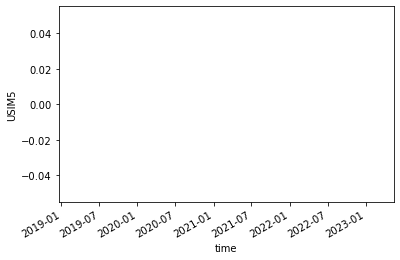

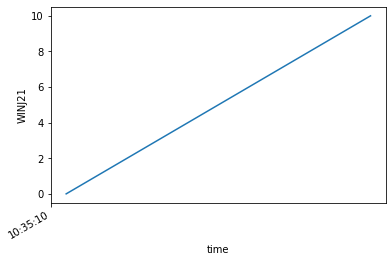

In [27]:
# iterage com cada item do grupo para personalizar o ylabel
for name, group in dfg:    
    group.plot(x='time', y='amount',ylabel=name, legend=False)

plt.show()

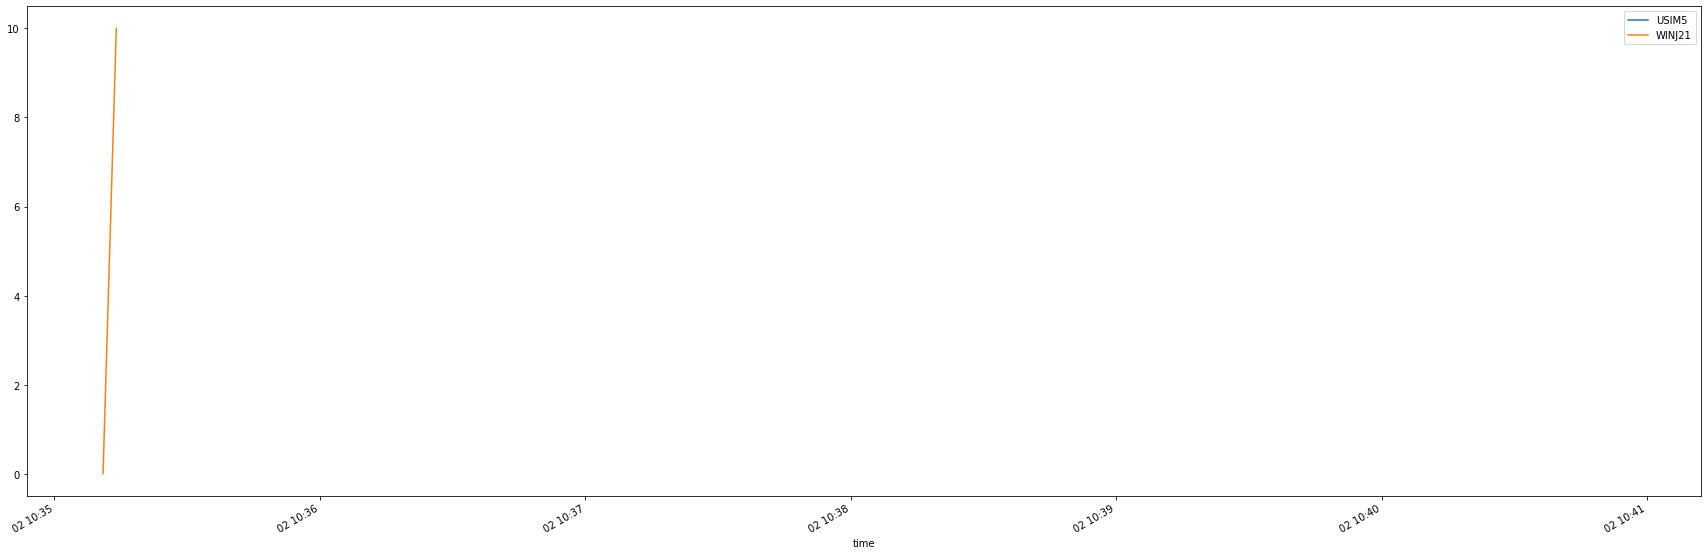

In [14]:
# iterage com o grupo para exibir todas as curvas no mesmo gráfico
fig, ax = plt.subplots(figsize=(30,10))
for name, group in dfg:    
    group.plot(x='time', y='amount', ax=ax, label=name)
plt.show()